# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by André Brodtkorb

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

import IPythonMagic
from Timer import Timer

In [2]:
import pytest
from ipytest import run_pytest, clean_tests

In [3]:
%setup_logging
%cuda_context_handler context

Python version 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:53:17) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Registering context in user workspace
Creating context
PyCUDA version 2018.1.1
CUDA version (8, 0, 0)
Driver version 9010
Using 'Quadro K2000' GPU
 => compute capability: (3, 0)
 => memory: 1895 / 1999 MB available
Created context handle <52789040>
Using CUDA cache dir /home/jobic/test/cuda/milan2018/MilanoGPU2018/andre/cuda_cache


In [4]:
cuda_kernel = """
__global__ void matrixVectorKernel(double* c, double* A, double* b, int a_rows, int a_cols) {
    unsigned int j = blockIdx.x*blockDim.x + threadIdx.x;
    
    //Out of bounds check
    if (j > a_rows) {
        return;
    }
    
    //Compute inner product of row of A with column of B
    float sum = 0.0f;
    for (int i=0; i<a_cols; ++i) {
        unsigned int k = j*a_cols + i;
        sum += A[k] * b[i];
    }
    
    //Write to global memory
    c[j] = sum;
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");

In [5]:
def gpuMatrixVector(a, b):
    context.synchronize()
        
        
    #Upload data to the device
    #NOTE: We need to make sure that a=(a_rows, a_columns)
    # and that b=(a_colmuns, 1) (column vector)
    # and that c=(a_rows, 1)
    with Timer("Data allocation") as t:
        a_g = GPUArray(a.shape, np.float64)
        b_g = GPUArray(b.shape, np.float64)
        c_g = GPUArray(a.shape[0], np.float64)
        context.synchronize()
        
    with Timer("A upload") as t:
        a_g.set(a)
        context.synchronize()
        
    with Timer("b upload") as t:
        b_g.set(b)
        context.synchronize()
    
    #NOTE: We need to change this so that the grid*block is x = 1, y = number of rows in A
    block_size = (128, 1, 1) #These need to be [x, y, z]
    grid_size = (int(np.ceil(a.shape[0] / 128)), 1, 1)

    #print("Block size is " + str(block_size))
    #print("Grid size is " + str(grid_size))
    
    #Execute program on device
    with Timer("Kernel execution") as t:
        kernel(c_g, a_g, b_g, np.int32(a.shape[0]), np.int32(a.shape[1]), block=block_size, grid=grid_size)
        context.synchronize()

    #Copy data from device to host
    with Timer("Allocate c") as t:
        c = np.empty((a.shape[0], 1), dtype=np.float64)
    with Timer("Download") as t:
        c_g.get(c)
        context.synchronize()
    
    #Return our computed matrix-vector product
    return c

In [6]:
nx = np.array([200, 400, 800, 1600, 3200, 6400, 8000, 10000])
ny = nx

print(nx, ny)

[  200   400   800  1600  3200  6400  8000 10000] [  200   400   800  1600  3200  6400  8000 10000]


In [7]:
times = np.empty_like(nx)
for i in range(len(nx)):
    print("Nx = " + str(nx[i]), flush=True)
    #Size of our test
    test_size = (nx[i], ny[i])

    #Create test input / output data
    with Timer("Create test data") as t:
        a = np.random.random(test_size).astype(np.float64)
        b = np.random.random((test_size[1], 1)).astype(np.float64)
    with Timer("Run whole function") as t:
        c = gpuMatrixVector(a, b)
    times[i] = t.msecs
    
print(nx*ny)
print(times)
    
    

"""fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(a)
plt.subplot(1,3,2)
plt.imshow(b)
plt.subplot(1,3,3)
plt.imshow(c)
fig.show()"""

Nx = 200


Create test data: 1.846313 ms
Data allocation: 1.546144 ms
A upload: 1.411438 ms
b upload: 0.992537 ms
Kernel execution: 3.175974 ms
Allocate c: 0.022888 ms
/home/jobic/anaconda3/envs/gpudev/lib/python3.6/site-packages/ipykernel/__main__.py:39: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
Download: 4.278898 ms
Run whole function: 20.333052 ms


Nx = 400


Create test data: 5.489111 ms
Data allocation: 1.687527 ms
A upload: 1.189232 ms
b upload: 0.982046 ms
Kernel execution: 0.910521 ms
Allocate c: 0.015974 ms
Download: 0.213385 ms
Run whole function: 13.293743 ms


Nx = 800


Create test data: 18.190145 ms
Data allocation: 0.819206 ms
A upload: 3.386021 ms
b upload: 0.797749 ms
Kernel execution: 1.469374 ms
Allocate c: 0.013590 ms
Download: 0.332832 ms
Run whole function: 13.026953 ms


Nx = 1600


Create test data: 52.868843 ms
Data allocation: 0.936747 ms
A upload: 12.872458 ms
b upload: 0.790119 ms
Kernel execution: 3.877878 ms
Allocate c: 0.013828 ms
Download: 1.091242 ms
Run whole function: 25.064945 ms


Nx = 3200


Create test data: 192.032337 ms
Data allocation: 1.177788 ms
A upload: 52.258015 ms
b upload: 0.836611 ms
Kernel execution: 18.068314 ms
Allocate c: 0.017166 ms
Download: 1.221657 ms
Run whole function: 79.734325 ms


Nx = 6400


Create test data: 736.355305 ms
Data allocation: 1.222849 ms
A upload: 198.377609 ms
b upload: 0.837326 ms
Kernel execution: 82.882404 ms
Allocate c: 0.014544 ms
Download: 0.369549 ms
Run whole function: 288.824797 ms


Nx = 8000


Create test data: 945.788622 ms
Data allocation: 2.199173 ms
A upload: 310.403585 ms
b upload: 0.647783 ms
Kernel execution: 129.801989 ms
Allocate c: 0.034809 ms
Download: 0.415087 ms
Run whole function: 449.825048 ms


Nx = 10000


Create test data: 1474.076033 ms
Data allocation: 1.755476 ms
A upload: 484.122753 ms
b upload: 0.358820 ms
Kernel execution: 211.913347 ms
Allocate c: 0.059366 ms
Download: 0.715733 ms
Run whole function: 707.185507 ms


[    40000    160000    640000   2560000  10240000  40960000  64000000
 100000000]
[ 20  13  13  25  79 288 449 707]


'fig = plt.figure()\nplt.subplot(1,3,1)\nplt.imshow(a)\nplt.subplot(1,3,2)\nplt.imshow(b)\nplt.subplot(1,3,3)\nplt.imshow(c)\nfig.show()'

update_title_pos
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/jobic/anaconda3/envs/gpudev/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
update_title_pos
update_title_pos
update_title_pos
update_title_pos


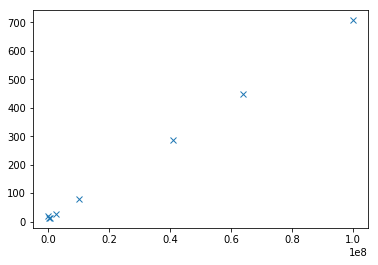

In [8]:
plt.figure()
plt.plot(nx*ny, times, 'x')

In [9]:
#Compute reference using Numpy
c_ref = np.dot(a, b)

#Sum of absolute differences
sad = np.sum(np.abs(c - c_ref))

#Print result
# print("C   = ", c)
# print("Ref = ", c_ref)
print("Sad = %.30f" % sad)
print("Per element error: " + str(sad / test_size[1]))

Sad = 30.624646187327925872523337602615
Per element error: 0.0030624646187327924


In [ ]:
clean_tests()

def test_gpuMatrixVector():
    #Let us test a matrix of size 1x1
    a = np.ones((1, 1), dtype=np.float32)
    b = 2*np.ones((1, 1), dtype=np.float32)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(2.0)
    
    #Test that the inner product works
    a = np.ones((1, 2), dtype=np.float32)
    b = 2*np.ones((2, 1), dtype=np.float32)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(4.0)
    
    #Test a general matrix
    test_size = (4, 3)
    a = np.random.random(test_size).astype(np.float32)
    b = np.random.random((test_size[1], 1)).astype(np.float32)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(a.dot(b), rel=1e-3)
    
run_pytest(filename='MatrixVectorTesting.ipynb', pytest_options=['-vvv'])